# Lesson 04 Assignment - Feature Selection

### Dataset
<a href='http://archive.ics.uci.edu/ml/machine-learning-databases/communities/'> Communities and Crime dataset</a>

The data combines socio-economic data from the 1990 US Census, law enforcement data from the 1990 US LEMAS survey, and crime data from the 1995 FBI UCR. 

Data Set Characteristics:  Multivariate<br/>
Number of Instances: 1994<br/>
Number of Attributes: 128<br/>
Missing Values? Yes<br/>

Numeric data normalized into the decimal range 0.00-1.00

Attribute to be predicted: Per Capita Violent Crimes

<b>Some Attribute Information</b>: (122 predictive, 5 non-predictive, 1 goal)<br/>
<u>state</u>: US state (by number) - not counted as predictive above, but if considered, should be consided nominal (nominal)<br/>
<u>county</u>: numeric code for county - not predictive, and many missing values (numeric)<br/>
<u>community</u>: numeric code for community - not predictive and many missing values (numeric)<br/>
<u>communityname</u>: community name - not predictive - for information only (string)<br/>
<u>fold</u>: fold number for non-random 10 fold cross validation, potentially useful for debugging, paired tests - not predictive (numeric)

<u>LemasGangUnitDeploy</u>: gang unit deployed (numeric - decimal - but really ordinal - 0 means NO, 1 means YES, 0.5 means Part Time)

<u>ViolentCrimesPerPop</u>: total number of violent crimes per 100K popuation (numeric - decimal) GOAL attribute (to be predicted)



### Task
Identify which are the most important features or attributes that contribute to crime

### Instructions
1. Read data.
2. Apply three techniques for filter selection: Filter methods, Wrapper methods, Embedded methods.
3. Describe your findings.

In [1]:
import pandas as pd
import numpy as np

import re
import urllib.request
import shutil

from itertools import combinations

from sklearn.metrics import mutual_info_score

import matplotlib.pyplot as plt
%matplotlib inline

## Load data

In [2]:
url_data = 'http://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.data'

local_path_data = './communities.data'

def load_data(a_url, path):
    """Return a DataFrame containing a dataset from url or local path."""
    print('Trying to load the data set from a local file if it exists...')
    try:
        data_set = pd.read_csv(path, sep = ',', header = None)
    except FileNotFoundError:
        print('\tFile not found, loading from Internet...')
        data_set = pd.read_csv(a_url, sep = ',', header = None)
        print('\t\tData loaded from url')
    else:
        print('\tData loaded from local file')
    
    return data_set

data = load_data(url_data, local_path_data)

Trying to load the data set from a local file if it exists...
	Data loaded from local file


## Download a file with feature names and extract feature names

In [3]:
# Download a file containing attribute names and save to current working directory
url_labels = 'http://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.names'
local_name = 'communities.names'
with urllib.request.urlopen(url_labels) as response, open(local_name, 'wb') as toF:
    shutil.copyfileobj(response, toF)

In [4]:
#  Extract feature names using regular expressions
with open('communities.names', 'r', encoding = 'utf-8') as fromF:
    text = fromF.read()
    feature_names = re.findall(r'@attribute (.*) .*', text)

print('Number of features:', len(feature_names))
print('First three features:', feature_names[:3])
print('Last three features:', feature_names[-3:])

Number of features: 128
First three features: ['state', 'county', 'community']
Last three features: ['LemasPctOfficDrugUn', 'PolicBudgPerPop', 'ViolentCrimesPerPop']


In [5]:
# Add attribute names to the dataframe from a list
data.columns = feature_names
print(data.shape)
data.head(4)

(1994, 128)


,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,?,?,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,?,?,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,?,?,?,?,0.00,?,0.67
2,24,?,?,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,?,?,?,?,0.00,?,0.43
3,34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,?,?,?,?,0.00,?,0.12


## Prepare data

Drop the first five attributes considered to be non-predictive by the dataset authors.

In [6]:
data.drop(feature_names[:5], axis = 1, inplace = True)
print(data.shape)
data.head(3)

(1994, 123)


,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.02,0.12,0.45,?,?,?,?,0.00,?,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.01,0.21,0.02,?,?,?,?,0.00,?,0.43


Replacing '?' with NaN.

In [7]:
data = data.replace(to_replace = '?', value = float('nan'))

In [8]:
print('Which columns have missing values and how many?')
col_with_miss_val = [(col_name, data[col_name].isnull().sum()) for col_name in data.columns if data[col_name].isnull().sum() > 0]
miss_col_names, miss_count = zip(*col_with_miss_val)
print(miss_col_names, miss_count)

Which columns have missing values and how many?
('OtherPerCap', 'LemasSwornFT', 'LemasSwFTPerPop', 'LemasSwFTFieldOps', 'LemasSwFTFieldPerPop', 'LemasTotalReq', 'LemasTotReqPerPop', 'PolicReqPerOffic', 'PolicPerPop', 'RacialMatchCommPol', 'PctPolicWhite', 'PctPolicBlack', 'PctPolicHisp', 'PctPolicAsian', 'PctPolicMinor', 'OfficAssgnDrugUnits', 'NumKindsDrugsSeiz', 'PolicAveOTWorked', 'PolicCars', 'PolicOperBudg', 'LemasPctPolicOnPatr', 'LemasGangUnitDeploy', 'PolicBudgPerPop') (1, 1675, 1675, 1675, 1675, 1675, 1675, 1675, 1675, 1675, 1675, 1675, 1675, 1675, 1675, 1675, 1675, 1675, 1675, 1675, 1675, 1675, 1675)


With only 1994 observations in the dataset, columns with 1675 missing values seem to be irrelevant.

In [9]:
# Remove columns which mostly contain NaN values
num_nan_values = 1675
nan_columns = [col_name for col_name in data.columns if data[col_name].isnull().sum() == num_nan_values]
print('{} columns to be removed because they mostly have NaN values:\n{}'.format(len(nan_columns), nan_columns))

22 columns to be removed because they mostly have NaN values:
['LemasSwornFT', 'LemasSwFTPerPop', 'LemasSwFTFieldOps', 'LemasSwFTFieldPerPop', 'LemasTotalReq', 'LemasTotReqPerPop', 'PolicReqPerOffic', 'PolicPerPop', 'RacialMatchCommPol', 'PctPolicWhite', 'PctPolicBlack', 'PctPolicHisp', 'PctPolicAsian', 'PctPolicMinor', 'OfficAssgnDrugUnits', 'NumKindsDrugsSeiz', 'PolicAveOTWorked', 'PolicCars', 'PolicOperBudg', 'LemasPctPolicOnPatr', 'LemasGangUnitDeploy', 'PolicBudgPerPop']


In [10]:
data.drop(nan_columns, axis = 1, inplace = True)
data.shape

(1994, 101)

In [11]:
# Replace the only other remaining missing value with mean
data['OtherPerCap'] = pd.to_numeric(data['OtherPerCap'], errors = 'coerse')
mean = np.nanmean(data['OtherPerCap'])
# print(mean)
nan_filter = np.isnan(data.loc[:, 'OtherPerCap'])
data.loc[nan_filter, 'OtherPerCap'] = mean
print('Any other missing values?', sum(data.isnull().sum()))

Any other missing values? 0


Splitting the dataset into data X and labels Y.

In [12]:
Y = data['ViolentCrimesPerPop']
X = data.drop('ViolentCrimesPerPop', axis = 1)
print('Shape of the label Y structure:', Y.shape, type(Y))
print('Shape of the data X structure:', X.shape, type(X))

Shape of the label Y structure: (1994,) <class 'pandas.core.series.Series'>
Shape of the data X structure: (1994, 100) <class 'pandas.core.frame.DataFrame'>


## Filter methods: 1 - Drop linearly correlated columns

In [13]:
# Use a correlation matrix to identify highly correlated features
correlation_matrix = X.corr()
# Use a transpose of the corr. matrix to extract column names that a given column is correlated with
correlation_matrix_T = correlation_matrix.T
correlated_feature_pairs = []

threshold_corrcoef = 0.8 # the choice is arbitrary
for i in range(len(correlation_matrix.columns)):  
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold_corrcoef:
            colname = correlation_matrix.columns[i]
            correlated_feature_pairs.append((correlation_matrix_T.columns[j],
                                             correlation_matrix.columns[i]))

In [14]:
print('Number of pairs of correlated features identified:', len(correlated_feature_pairs))
print('First three pairs:', correlated_feature_pairs[:3])

Number of pairs of correlated features identified: 127
First three pairs: [('agePct12t21', 'agePct12t29'), ('agePct12t21', 'agePct16t24'), ('agePct12t29', 'agePct16t24')]


An example of linearly correlated features with corr. coef. above 0.8


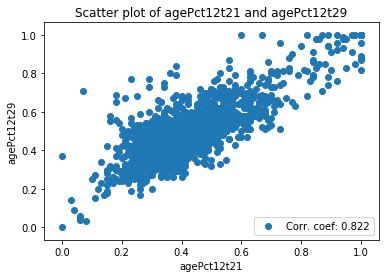

In [15]:
print('An example of linearly correlated features with corr. coef. above 0.8')
corr_coeff = np.corrcoef(X[correlated_feature_pairs[0][0]], X[correlated_feature_pairs[0][1]])[0][1]
plt.scatter(X[correlated_feature_pairs[0][0]], 
            X[correlated_feature_pairs[0][1]], 
            label = 'Corr. coef: %0.3f' % corr_coeff)
plt.title('Scatter plot of {} and {}'.format(correlated_feature_pairs[0][0], correlated_feature_pairs[0][1]))
plt.xlabel(correlated_feature_pairs[0][0])
plt.ylabel(correlated_feature_pairs[0][1])
plt.legend(loc = 'lower right')
plt.show()

In [16]:
def choose_lower_corr(X_dataframe, Y_dataframe, a_tuple):
    """Return one of two column names in a_tuple with lower corr.coef with Y label."""
    col_num0 = a_tuple[0]
    col_num1 = a_tuple[1]
    coef0 = np.corrcoef(X_dataframe[col_num0], Y_dataframe)[0][1]
    coef1 = np.corrcoef(X_dataframe[col_num1], Y_dataframe)[0][1]
    if coef0 <= coef1:
        return col_num0
    return col_num1

corr_columns_to_drop = set()
for feature_pair in correlated_feature_pairs:
    corr_columns_to_drop.add(choose_lower_corr(X, Y, feature_pair))

I will drop that column from each pair identified above which has a lower corr. coef. with the target label Y. For example:

In [17]:
print('The first pair of columns in <correlated_feature_pairs> list:', correlated_feature_pairs[0])
print('Their corr. coef. is:', np.corrcoef(X[correlated_feature_pairs[0][0]], 
                                           X[correlated_feature_pairs[0][1]])[0][1])
print('{} and label Y corr. coef.: {}'.format(correlated_feature_pairs[0][0], 
                                              np.corrcoef(X[correlated_feature_pairs[0][0]], Y)[0][1]))
print('{} and label Y corr. coef. {}:'.format(correlated_feature_pairs[0][1],
                                              np.corrcoef(X[correlated_feature_pairs[0][1]], Y)[0][1]))
# print('Column 18 has lower correlation coeff.')
col_to_drop = choose_lower_corr(X, Y, correlated_feature_pairs[0])
print('Function choose_lower_corr() returns', col_to_drop, 'which will be dropped')

The first pair of columns in <correlated_feature_pairs> list: ('agePct12t21', 'agePct12t29')
Their corr. coef. is: 0.8224241501446315
agePct12t21 and label Y corr. coef.: 0.06047724865794855
agePct12t29 and label Y corr. coef. 0.15335668826271853:
Function choose_lower_corr() returns agePct12t21 which will be dropped


In [18]:
print('Number and names of correlated features which will be removed:')
print(len(corr_columns_to_drop))
print(sorted(list(corr_columns_to_drop)))

Number and names of correlated features which will be removed:
53
['HousVacant', 'MalePctDivorce', 'MedRent', 'NumInShelters', 'NumUnderPov', 'OwnOccLowQuart', 'OwnOccMedVal', 'PctEmploy', 'PctFam2Par', 'PctForeignBorn', 'PctHousNoPhone', 'PctImmigRec5', 'PctImmigRec8', 'PctImmigRecent', 'PctKids2Par', 'PctLargHouseFam', 'PctLargHouseOccup', 'PctLess9thGrade', 'PctNotSpeakEnglWell', 'PctOccupMgmtProf', 'PctPersOwnOccup', 'PctRecImmig10', 'PctRecImmig5', 'PctRecImmig8', 'PctRecentImmig', 'PctSameHouse85', 'PctSpeakEnglOnly', 'PctUnemployed', 'PctWorkMom', 'PctYoungKids2Par', 'PersPerFam', 'PersPerOccupHous', 'PersPerOwnOccHous', 'PersPerRentOccHous', 'RentHighQ', 'RentLowQ', 'RentMedian', 'TotalPctDiv', 'agePct12t21', 'agePct16t24', 'agePct65up', 'householdsize', 'medFamInc', 'medIncome', 'numbUrban', 'pctWInvInc', 'pctWWage', 'perCapInc', 'population', 'racePctHisp', 'racePctWhite', 'racepctblack', 'whitePerCap']


In [19]:
# Drop linearly correlated columns
X = X.drop(corr_columns_to_drop, axis = 1)
print('Dataset shape after removing correlated features:', X.shape)

Dataset shape after removing correlated features: (1994, 47)


## Filter methods: 2 - Drop columns with a high mutual information score

In [20]:
def calc_MI(x, y, bins):
    """Return a mutual information score for two features."""
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

In [21]:
current_columns = list(X.columns)
# All possible combinations of columns by using itertools
column_combinations = combinations(current_columns, 2)

# List of columns with high mutual information score - I chose 0.6 as a threshold
mutual_info_columns_pairs = []
for column_pair in column_combinations:
    column_one = column_pair[0]
    column_two = column_pair[1]
    mi = calc_MI(X[column_one], 
                 X[column_two], 20)
    if mi > 0.6:
        mutual_info_columns_pairs.append((column_one, column_two))

In [22]:
print('Number of pairs of features with high mutual information score identified:')
print(len(mutual_info_columns_pairs))
print(mutual_info_columns_pairs)

Number of pairs of features with high mutual information score identified:
6
[('pctWPubAsst', 'PctPopUnderPov'), ('PctNotHSGrad', 'PctBSorMore'), ('PctNotHSGrad', 'PctOccupManu'), ('PctBSorMore', 'PctOccupManu'), ('PctHousLess3BR', 'MedNumBR'), ('PctHousLess3BR', 'PctHousOwnOcc')]


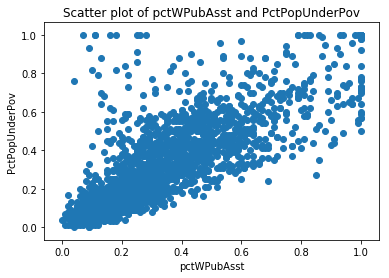

Mutual information score = 0.678


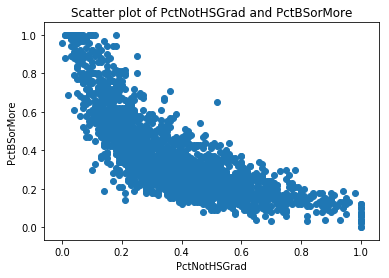

Mutual information score = 0.636


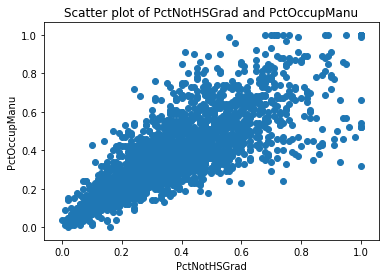

Mutual information score = 0.625


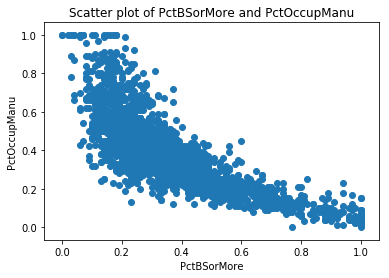

Mutual information score = 0.73


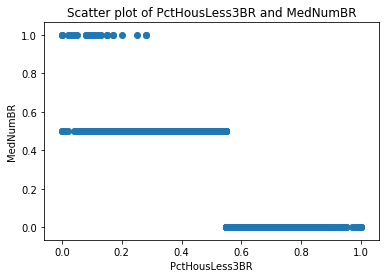

Mutual information score = 0.665


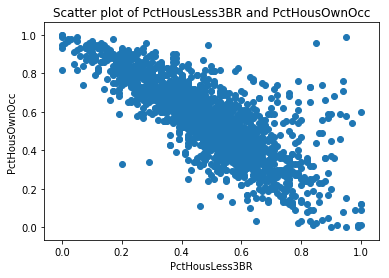

Mutual information score = 0.651


In [23]:
# Plot the above column pairs
for col_pair in mutual_info_columns_pairs:
    column_one, column_two = col_pair
    plt.scatter(X[column_one], X[column_two])
    plt.title('Scatter plot of {} and {}'.format(column_one, column_two))
    plt.xlabel(column_one)
    plt.ylabel(column_two)
    plt.show()
    mi= calc_MI(X[column_one], X[column_two], 20)
    print('Mutual information score =', round(mi, 3))

In [24]:
def choose_lower_mi(X_dataframe, Y_data, a_tuple):
    """Return one of two column names in a_tuple with a lower MI score with Y label."""
    col_num0 = a_tuple[0]
    col_num1 = a_tuple[1]
    mi0 = calc_MI(X_dataframe[col_num0], Y_data, 20)
    mi1 = calc_MI(X_dataframe[col_num1], Y_data, 20)
    if mi0 <= mi1:
        return col_num0
    return col_num1

mi_based_columns_to_drop = set()
for feature_pair in mutual_info_columns_pairs:
    mi_based_columns_to_drop.add(choose_lower_mi(X, Y, feature_pair))
print('Number and names of features with a high MI score to be removed:')
print(len(mi_based_columns_to_drop))
print(mi_based_columns_to_drop)

Number and names of features with a high MI score to be removed:
5
{'PctHousLess3BR', 'MedNumBR', 'PctBSorMore', 'pctWPubAsst', 'PctOccupManu'}


In [25]:
# Drop columns with high mutual information score
X = X.drop(mi_based_columns_to_drop, axis = 1)
print('Dataset shape after removing features with high mutual correlation score', X.shape)

Dataset shape after removing features with high mutual correlation score (1994, 42)


## Wrapper methods: 1 - Backward Variables Selection

In [26]:
# Recursive Feature Elimination for backward model selection
from sklearn.datasets import make_friedman1
from sklearn.feature_selection import RFE #Recursive Feature Elimination
from sklearn.linear_model import LinearRegression

estimator = LinearRegression()
selector = RFE(estimator, 8, step=1)#select 8 features. Step=1 means each step only remove 1 variable from the model
selector = selector.fit(X, Y)  # learn from dataset and do backward variable selection
print(selector.support_) # The mask of selected features. Which variables were selected
print(selector.ranking_) # selected features are ranked 1. The highest-ranking variable is deselected first

[False  True False False False False False False False False False False
 False False False False  True  True False False  True False False  True
  True False False False False False False False False False  True False
 False False  True False False False]
[13  1 10 35  8  9 22 19 16  7 23 18 15 20 31  3  1  1 21  6  1  2 32  1
  1 33  5 17 27 34 24 11 12  4  1 29 26 28  1 25 30 14]


In [27]:
print('Features selected by Backward Variables Selection:')
backward_selected_features = X.columns[selector.support_]
print(backward_selected_features)

Features selected by Backward Variables Selection:
Index(['agePct12t29', 'FemalePctDiv', 'PctTeen2Par', 'PctIlleg',
       'PctPersDenseHous', 'PctHousOccup', 'NumStreet', 'LandArea'],
      dtype='object')


## Wrapper methods: 2 - Forward Stepwise Feature Selection

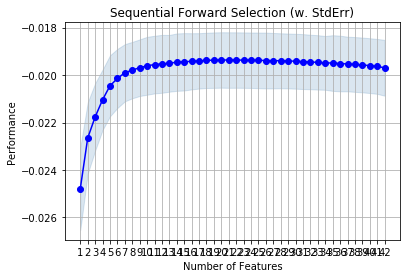

In [28]:
# Forward Stepwise Feature Selection
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_boston
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
%matplotlib inline

lr = LinearRegression()

sfs = SFS(lr, 
          k_features = 42, # k_features has to be smaller or equal to the number of features. 
                           # If equal to, it starts from
                           # intercept to the full model
          forward = True,
          floating = False, 
          scoring = 'neg_mean_squared_error',
          cv = 10)  # cross validation

sfs = sfs.fit(X, Y)
fig = plot_sfs(sfs.get_metric_dict(), kind = 'std_err')
# Wide blue band --  different combinations of each number of features
# Dark blue dots -- average performance
plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

In [29]:
# If I took only 8 features, what would be the features selected
scores = sfs.get_metric_dict()[8]
# Selected features
print('Features selected by Forward Stepwise Feature Selection:')
farward_selected_features = scores['feature_names']
print(farward_selected_features)

Features selected by Forward Stepwise Feature Selection:
('pctUrban', 'pctWSocSec', 'FemalePctDiv', 'PctIlleg', 'PctPersDenseHous', 'PctHousOccup', 'PctVacantBoarded', 'NumStreet')


## LASSO

In [30]:
# LASSO
from sklearn import linear_model

alpha = 0.007 # Increasing alpha can shrink more variable coefficients to 0
clf = linear_model.Lasso(alpha=alpha)
clf.fit(X, Y)

print('Model coefficients:')
print(clf.coef_)
print('Intercept')
print(clf.intercept_)

Model coefficients:
[ 0.         -0.          0.00390456 -0.          0.          0.
 -0.         -0.         -0.         -0.         -0.          0.
  0.         -0.         -0.          0.          0.11285109 -0.00293801
 -0.          0.          0.54102569  0.          0.          0.05831828
 -0.00167692 -0.          0.0065617  -0.         -0.          0.
 -0.          0.          0.         -0.          0.         -0.
  0.         -0.          0.          0.          0.          0.0018716 ]
Intercept
0.03552253199109903


In [31]:
print('Feature names selected by LASSO:')
mask = (clf.coef_ != 0)
lasso_features = X.columns[mask]
print(lasso_features)
print('Number of features selected:', len(lasso_features))

Feature names selected by LASSO:
Index(['pctUrban', 'FemalePctDiv', 'PctTeen2Par', 'PctIlleg',
       'PctPersDenseHous', 'PctHousOccup', 'PctVacantBoarded',
       'LemasPctOfficDrugUn'],
      dtype='object')
Number of features selected: 8


## Selecting top few features

In [32]:
# Take a set of the resulting three lists of selected features
combined_features = set()
for features_list in (backward_selected_features, farward_selected_features, lasso_features):
    for feature_name in features_list:
        combined_features.add(feature_name)
print('Number of unique features across the three lists:', len(combined_features))

Number of unique features across the three lists: 12


Feature name: PctTeen2Par
mi = 0.37780313500275037
corr_coef =  -0.6615816444304081


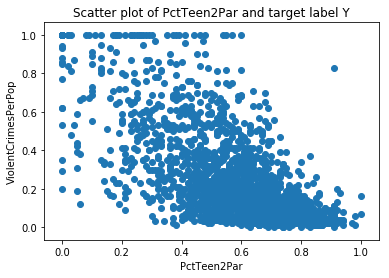

Feature name: PctPersDenseHous
mi = 0.34687281163845785
corr_coef =  0.4529009069340085


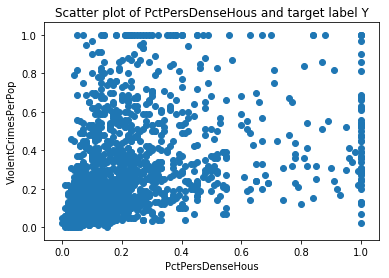

Feature name: FemalePctDiv
mi = 0.3346540239246115
corr_coef =  0.5560318773346954


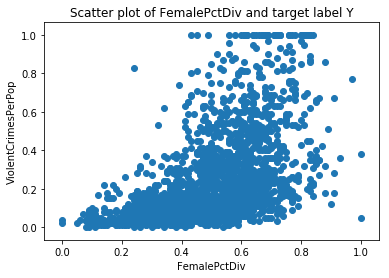

Feature name: PctVacantBoarded
mi = 0.21079440467227545
corr_coef =  0.4828157989468481


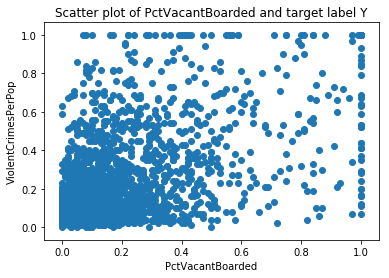

Feature name: LemasPctOfficDrugUn
mi = 0.1624713254607254
corr_coef =  0.34862725802493083


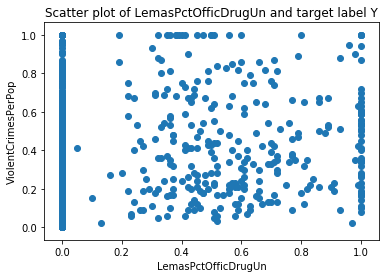

Feature name: pctUrban
mi = 0.08120041281669016
corr_coef =  0.08202541988301545


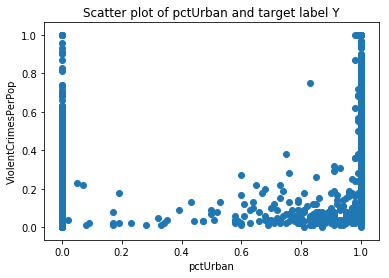

Feature name: PctIlleg
mi = 0.4743600439133835
corr_coef =  0.7379565498586633


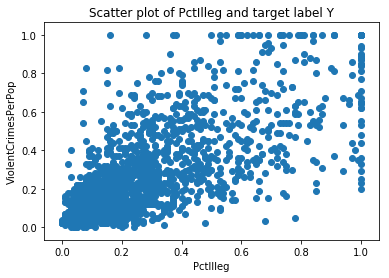

Feature name: LandArea
mi = 0.08518406767405565
corr_coef =  0.19679989115428478


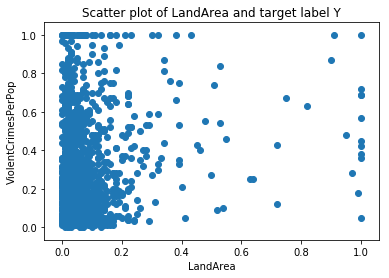

Feature name: pctWSocSec
mi = 0.09004382038403191
corr_coef =  0.11797715541014513


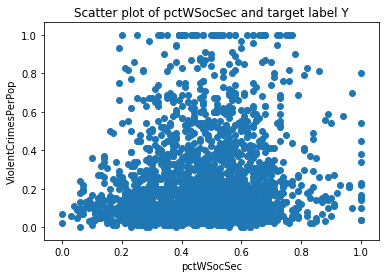

Feature name: NumStreet
mi = 0.11695568537112239
corr_coef =  0.3402767993993661


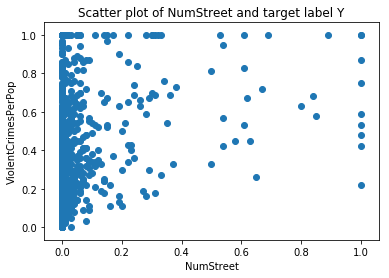

Feature name: agePct12t29
mi = 0.1436736399228316
corr_coef =  0.15335668826271853


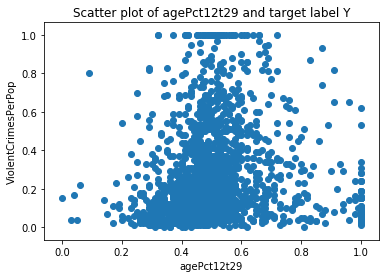

Feature name: PctHousOccup
mi = 0.17326923229050264
corr_coef =  -0.3190096545901865


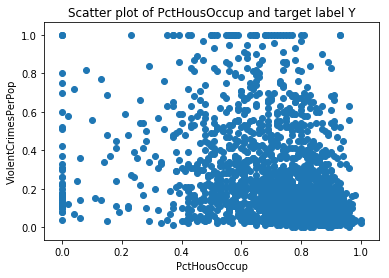

In [33]:
# Plot and calculate mi and corr. coef. for each feature and the target label Y
combined_features_list = list(combined_features)
for feature in combined_features_list:
    plt.scatter(X[feature], Y)
    print('Feature name:', feature)
    print('mi =', calc_MI(X[feature], Y, 20))
    print('corr_coef = ', np.corrcoef(X[feature], Y)[0][1])
    plt.title('Scatter plot of {} and target label Y'.format(feature))
    plt.xlabel(feature)
    plt.ylabel('ViolentCrimesPerPop')
    plt.show()

## Findings

The <b>original dataset</b> contains <b>127 attributes</b> (without counting the target label). 

During the Data Preparation stage I <b>removed 5 attributes</b> which are considered to be non-predictive by the dataset authors. Then I <b>removed 22 attributes</b> each of which had 1675 missing values out of the total 1994 observations in the dataset. That  reduced the number of attributes to 100.

Application of <b>two filter methods</b> - <b>elimination of linearly correlated features</b> (with a correlation coefficient above 0.8) and <b>features with a high mutual information score</b> (above 0.6) <b>removed 53 and 6 attributes</b>, respectively.  I determined both thresholds by trying out different values and observing which scatter plots seemed to contain a visible pattern. When applying these selection methods, given each identified pair of attributes, I removed that attribute for which the correlation coefficient or the mutual information score between the attribute and the label Y was lower.

Application of the two filter methods brought down the number of attributes to 42.

With the remaining 42 attributes, by using <b>two wrapper methods</b> — <b>Backward Variables Selection</b> and <b>Forward Stepwise Feature Selection</b> — I <b>selected 8 attributes</b> in each case. I determined that number by observing a plot of the performance versus the number of attributes and by using the results of the LASSO modelling. The attributes produced by these methods are overlapping but not totally identical.

Finally, a <b>LASSO regression model</b> with alpha = 0.007 <b>picked 8 attributes</b>.

I wanted to get <b>several top features</b> contributing to crime. To do that, I took a set of the three lists of attributes generated by the two wrapper methods and the LASSO model to obtain 12 unique attributes. Then I plotted them against the target label and calculated their scores to arrive at the following <b>final 5 attributes</b> which seem to have the greatest impact on the crime rate per capita according to this dataset:

<u>PctIlleg</u>: percentage of kids born to never married<br/>
<u>PctPersDenseHous</u>: percent of persons in dense housing<br/>
<u>FemalePctDiv</u>: percentage of females who are divorced<br/>
<u>PctTeen2Par</u>: percent of kids age 12-17 in two parent households<br/>
<u>PctVacantBoarded</u>: percent of vacant housing that is boarded up<br/>

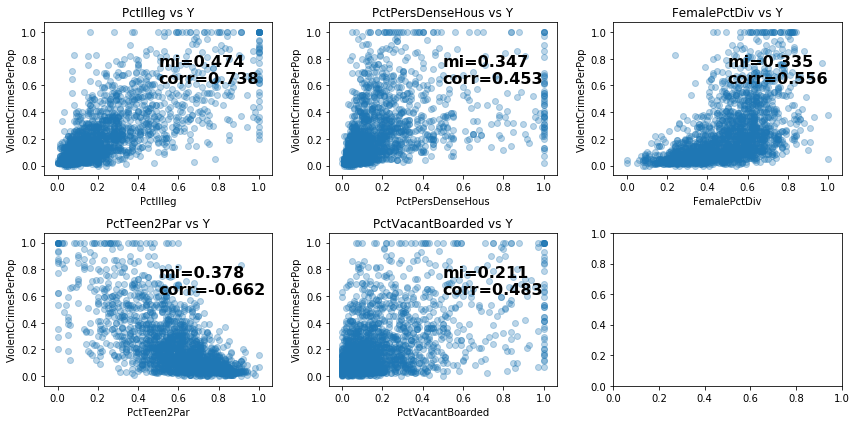

In [34]:
# Plot 5 top features selected
feat_list = ['PctIlleg', 'PctPersDenseHous', 'FemalePctDiv', 'PctTeen2Par', 'PctVacantBoarded']
fig, ((ax0, ax1, ax2), (ax3, ax4, _)) = plt.subplots(nrows = 2, ncols = 3, figsize=(12, 6))
for axis, feature in zip([ax0, ax1, ax2, ax3, ax4], feat_list):
    mi = calc_MI(X[feature], Y, 20)
    corr_coef = np.corrcoef(X[feature], Y)[0][1]
    text_str = 'mi={:.3f}\ncorr={:.3f}'.format(mi, corr_coef)
    axis.scatter(X[feature], Y, alpha = 0.3)
    axis.set_title('{} vs Y'.format(feature))
    axis.set_xlabel(feature)
    axis.set_ylabel('ViolentCrimesPerPop')
    axis.text(0.5, .6, text_str, fontsize = 16, weight = 'bold', transform = axis.transAxes)

plt.tight_layout()
plt.show()